In [1]:
import pandas as pd
import re
import numpy as np
from sklearn import datasets
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from joblib import dump, load

from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline

import nltk
from nltk.stem import WordNetLemmatizer

In [2]:
def preparationData(data):
    correct_text = []
    for text in data:
        correct = text.lower()
        correct = nltk.word_tokenize(correct)
        correct = ' '.join([lemmatizer.lemmatize(word) for word in correct])
        correct = re.sub("[^a-zA-Z0-9$ ]", "", correct)
        correct_text.append(correct)
    data = np.array(correct_text)
    
    vc = Tokenizer()
    vc.fit_on_texts(data)    
    %store vc
    _X = vc.texts_to_sequences(data)  
    
    X = []
    for x in _X:
        x = np.asarray(x)
        X.append(x)
    X = pad_sequences(X)

def sizeClusters(X, N):
    a = [0] * N
    for x in X:
        for i in range(N):
            if x == i:
                a[i] += 1
    print(a)
    print('')
                          
# TPIC - True Positive In Cluster, AIC - All In Cluster, AP - TP + FP. Для будущей проверки
def TPIC(X,Y,N):
    TPIC = 0
    for n in range(len(X)):
        if (X[n] == N and Y[n] != []):
            TPIC+=1
    return TPIC

def AIC(X,N):
    AIC = 0
    for x in X:
        if x == N:
            AIC+=1
    return AIC

def AP(Y):
    AP = 0
    for y in Y:
        if y != []:
            AP+=1
    return AP

def recall(X,Y,N):
    for n in range(N):
        _TPIC = TPIC(X,Y,n)
        _AIC = AIC(X,n)
        print(_TPIC/_AIC)
    print('')
        
def acc(X,Y,N):
    for n in range(N):
        _TPIC = TPIC(X,Y,n)
        _AP = AP(Y)
        print(_TPIC/_AP)
    print('')
    
def complexTest (X,Y,N):
    recall(X,Y,N)
    acc(X,Y,N)
    sizeClusters(X, N)

In [3]:
# загружаем нужные текствые данные из файла
data = pd.read_csv('reddit_wsb.csv').iloc[:, 0].values

# ининциализируем лемматизатор
lemmatizer = WordNetLemmatizer()    
preprocess = Pipeline(
    [
        ('prep', preprocessData(data)),
    ])

clusterer = Pipeline(
       [
           ("GM",GaussianMixture(n_components = 2, max_iter = 400, init_params = 'random', covariance_type = 'full', tol = 1, reg_covar = 1),),
       ])

pipe = Pipeline(
    [
        ('preprocess', preprocess),
        ("clusterer", clusterer),
    ]
)

# обучаем модель
pipe.fit(X)
dump(pipe, 'spam.joblib') 

NameError: name 'Pipeline' is not defined

0.6212547270435372
0.48693225069779245
0.9092242194891201
0.09077578051087985
[30939, 3941]



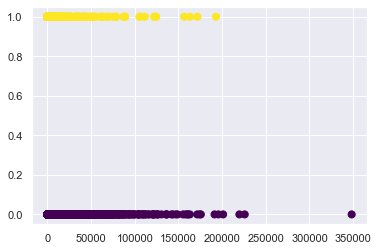

In [134]:


# TPIC - True Positive In Cluster, AIC - All In Cluster, AP - TP + FP. Для будущей проверки
def TPIC(X,Y,N):
    TPIC = 0
    for n in range(len(X)):
        if (X[n] == N and Y[n] != []):
            TPIC+=1
    return TPIC

def AIC(X,N):
    AIC = 0
    for x in X:
        if x == N:
            AIC+=1
    return AIC

def AP(Y):
    AP = 0
    for y in Y:
        if y != []:
            AP+=1
    return AP

def recall(X,Y,N):
    for n in range(N):
        _TPIC = TPIC(X,Y,n)
        _AIC = AIC(X,n)
        print(_TPIC/_AIC)
        
def acc(X,Y,N):
    for n in range(N):
        _TPIC = TPIC(X,Y,n)
        _AP = AP(Y)
        print(_TPIC/_AP)

# загружаем текстовые данные и ссылки
data = pd.read_csv('reddit_wsb.csv').iloc[:, 0].values
urls = pd.read_csv('reddit_wsb.csv').iloc[:, 3].values

# оставляем только ссылки на посты 'wall street bets'
correct_url = []
for url in urls:
    correct_url.append(re.findall(r'^(.*?)comments.*', url))

lemmatizer = WordNetLemmatizer()    

correct_text = []
for text in data:
    correct = text.lower()
    correct = nltk.word_tokenize(correct)
    correct = ' '.join([lemmatizer.lemmatize(word) for word in correct])
    correct = re.sub("[^a-zA-Z0-9$ ]", "", correct)
    correct_text.append(correct)
data = np.array(correct_text)

# загрудаем модель со словарем
model = load('spam.joblib') 
%store -r vc
# X = vc.transform(data)

X = vc.texts_to_sequences(data)
X = pad_sequences(X)

# предсказываем по данным и проверяем качество кластеризации
x_kmeans = model.predict(X)

n = np.amax(x_kmeans)+1
complexTest(x_kmeans, correct_url, n)
plt.scatter(pd.read_csv('reddit_wsb.csv').iloc[:,1], x_kmeans, c=x_kmeans, s=50, cmap='viridis');

In [15]:
import re
import pandas as pd
import numpy as np
from sklearn import datasets
from joblib import dump, load

import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler
from sklearn.decomposition import TruncatedSVD

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import silhouette_score


In [16]:
def preparationData(data):
    correct_text = []
    for text in data:
        correct = text.lower()
        correct = nltk.word_tokenize(correct)
        correct = ' '.join([lemmatizer.lemmatize(word) for word in correct])
        correct = re.sub("[^a-zA-Z0-9$ ]", "", correct)
        correct_text.append(correct)
    data = np.array(correct_text)
    return data

def sizeClusters(X, N):
    a = [0] * N
    for x in X:
        for i in range(N):
            if x == i:
                a[i] += 1
    print(a)
    print('')
                          
# TPIC - True Positive In Cluster, AIC - All In Cluster, AP - TP + FP. Для будущей проверки
def TPIC(X,Y,N):
    TPIC = 0
    for n in range(len(X)):
        if (X[n] == N and Y[n] != []):
            TPIC+=1
    return TPIC

def AIC(X,N):
    AIC = 0
    for x in X:
        if x == N:
            AIC+=1
    return AIC

def AP(Y):
    AP = 0
    for y in Y:
        if y != []:
            AP+=1
    return AP

def recall(X,Y,N):
    for n in range(N):
        _TPIC = TPIC(X,Y,n)
        _AIC = AIC(X,n)
        print(_TPIC/_AIC)
    print('')
        
def acc(X,Y,N):
    for n in range(N):
        _TPIC = TPIC(X,Y,n)
        _AP = AP(Y)
        print(_TPIC/_AP)
    print('')
    
def complexTest (X,Y,N):
    recall(X,Y,N)
    acc(X,Y,N)
    sizeClusters(X, N)

In [ ]:
data = pd.read_csv('reddit_wsb.csv').iloc[:, 0].values

# ининциализируем лемматизатор
lemmatizer = WordNetLemmatizer()

# обрабатываем текст
data = preparationData(data)
preprocessor = Pipeline([
         ('tfidf', TfidfVectorizer(min_df = 500, stop_words = 'english')),
         ("svd", TruncatedSVD(n_components=2, random_state=42)),
     ])
clusterer = Pipeline(
       [
           ("kmeans", KMeans(n_clusters= 4, init="k-means++", n_init=20, max_iter=400, random_state=42,),),
       ]
)
model = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)
vc = TfidfVectorizer(min_df = 300, stop_words = 'english')
X = vc.fit_transform(data)

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)  
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

# model.fit(data)
# dump(model, 'spam.joblib') 

0.587354214611694
0.6314699792960663
0.6812358703843255
0.6958499147242752

0.7122989593188269
0.14427625354777673
0.08552507095553454
0.057899716177861875

[25637, 4830, 2654, 1759]

0.7610270396350038


Text(0, 0.5, 'Distance')

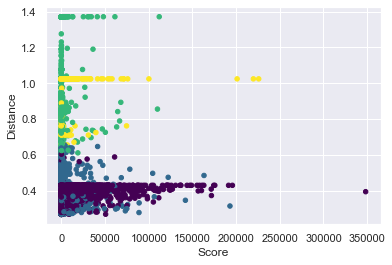

In [25]:
# загружаем текстовые данные и ссылки
data = pd.read_csv('reddit_wsb.csv').iloc[:, 0].values
urls = pd.read_csv('reddit_wsb.csv').iloc[:, 3].values

lemmatizer = WordNetLemmatizer()
# оставляем только ссылки на посты 'wall street bets'
correct_url = []
for url in urls:
    correct_url.append(re.findall(r'^(.*?)comments.*', url))

# подготавливаем данные
data = preparationData(data)

# загрудаем готовую модель
model = load('spam.joblib') 

# предсказываем по данным и проверяем качество кластеризации
x_kmeans = model.predict(data)
n = np.amax(x_kmeans)+1
complexTest(x_kmeans, correct_url, n)

distances_xy = model.transform(data)
distances = []
for element in distances_xy:
    distances.append(np.sqrt(element[0] **2 + element[1] **2))

print(silhouette_score(distances_xy, x_kmeans))

fig, ax = plt.subplots()
ax.scatter(pd.read_csv('reddit_wsb.csv').iloc[:,1], distances, c=x_kmeans, s=20, cmap='viridis')
ax.set_xlabel('Score')
ax.set_ylabel('Distance')